# Train ML Model
I am going to have an explore and see what is best though, as usual, I expect XGBoost will be all conquering for this discussion because again we are working with tabular data. I will read it in using Polars this time for performance reasons.

In [145]:
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import Booster
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
hep.style.use(hep.style.ROOT)

In [146]:
column_names = [
    "straw1x", "straw1y", "trim5x", "trim5y", "tktag", "tgtk", "trich",
    "mm2rich", "mm2nom", "mm2", "p", "prich", "vtxz", "vtxx", "vtxy",
    "thetax", "thetay", "rstraw1", "nktaghits", "ngtkhits" 
]

## Defining Features
For the time being I will use the exact same set of features and the same training sets as the ROOT TMVA that is currently implemented. Then we can evaluate the performance differences if any and start tuning from this baseline.

In [147]:
features = [
    "straw1x", "straw1y", "trim5x", "trim5y", "rstraw1", "vtxz", "vtxx", "vtxy", "thetax", "thetay",
]

In [148]:
signal = pl.read_csv("data/BDT_Train_KpinnNoovCombined_07_05_2024.txt", has_header=False)
signal = signal.drop("column_21")
signal.columns = column_names
signal.head()

straw1x,straw1y,trim5x,trim5y,tktag,tgtk,trich,mm2rich,mm2nom,mm2,p,prich,vtxz,vtxx,vtxy,thetax,thetay,rstraw1,nktaghits,ngtkhits
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
312.095,-131.105,-345.227,204.3,18.3799,18.1938,18.2787,-0.002707,0.003251,0.002403,25.1484,26.0095,153.006,66.5434,-6.06644,0.008046,-0.004102,248.325,19,1
634.572,-176.502,-56.6356,7.3429,2.08454,2.17705,2.00025,0.0518736,0.0456794,0.0504472,18.0189,17.3942,107.088,-11.888,-4.342,0.0084494,-0.002254,561.818,20,1
-83.6746,-207.629,69.7437,123.733,2.69263,2.86549,2.63019,0.058194,0.0505023,0.0501381,32.2208,30.0798,132.043,12.9672,0.940185,-0.001878,-0.004056,278.008,24,1
278.088,25.8314,-126.514,-25.6616,8.32454,8.32077,8.39304,0.0666234,0.0460587,0.0493646,42.081,36.9081,134.166,33.7764,-5.73591,0.004952,0.00063,178.764,18,1
182.272,-94.061,-422.501,472.514,21.8005,21.5653,21.5731,0.002001,-0.001506,0.004035,19.4689,19.8229,169.853,80.9583,0.434846,0.007406,-0.006932,124.178,14,1


<Figure size 1000x1000 with 0 Axes>

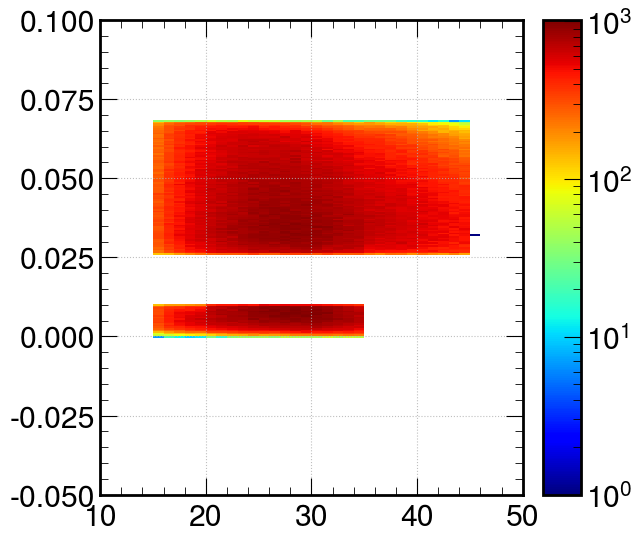

In [149]:
def missing_mass_plot(df):
    plt.clf()
    plt.figure(figsize=(7, 6))
    h, xbins, ybins = np.histogram2d(df["p"].to_numpy(), df["mm2"].to_numpy(), bins=(np.linspace(10, 50, 41), np.linspace(-0.05, 0.1, 300)))
    hep.hist2dplot(h, xbins, ybins, cmap="jet", norm=LogNorm())
    plt.grid()
    plt.tight_layout()
    plt.show()

missing_mass_plot(signal)

In [150]:
bkg = pl.read_csv("data/BDT_Train_2022_Upstream_v1.txt", has_header=False)
bkg = bkg.drop("column_21")
bkg.columns = column_names

Constrain the background sample to the signal region (should actually be done on the analyser level, this was an oversight).

In [151]:
bkg = bkg.filter(
    ((pl.col("mm2").is_between(0.0, 0.01)) & (pl.col("p").is_between(15.0, 35.0))) |
    (pl.col("mm2").is_between(0.026, 0.068))
)

<Figure size 1000x1000 with 0 Axes>

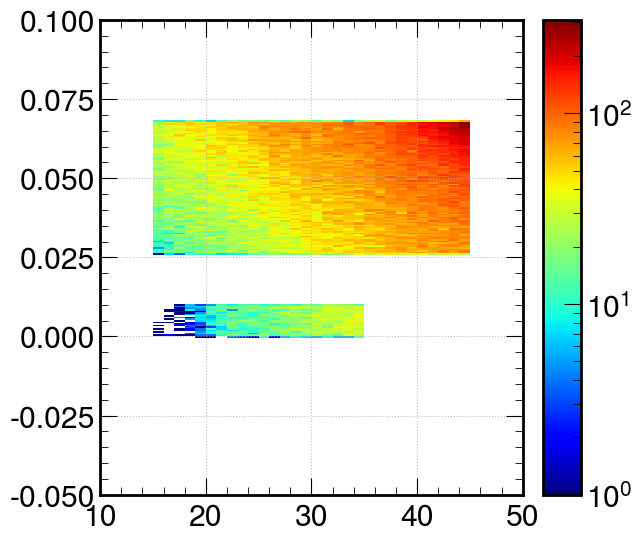

In [152]:
missing_mass_plot(bkg)

## Making Training Samples

In [153]:
# Add target indicators
signal = signal.with_columns(pl.lit(1).alias('isSignal'))
bkg = bkg.with_columns(pl.lit(0).alias('isSignal'))

In [154]:
# Feature engineering (add new features)
signal = signal.with_columns(pl.lit((signal.select("p") - signal.select("prich")).to_numpy().flatten()).alias("pprich"))
bkg = bkg.with_columns(pl.lit((bkg.select("p") - bkg.select("prich")).to_numpy().flatten()).alias("pprich"))

signal = signal.with_columns(pl.lit((signal.select("mm2") - signal.select("mm2nom")).to_numpy().flatten()).alias("dmm2nom"))
bkg = bkg.with_columns(pl.lit((bkg.select("mm2") - bkg.select("mm2nom")).to_numpy().flatten()).alias("dmm2nom"))

signal = signal.with_columns(pl.lit((signal.select("mm2") - signal.select("mm2rich")).to_numpy().flatten()).alias("dmm2rich"))
bkg = bkg.with_columns(pl.lit((bkg.select("mm2") - bkg.select("mm2rich")).to_numpy().flatten()).alias("dmm2rich"))

In [155]:
# Combine the dataframes together
df = pl.concat([signal, bkg], how='vertical')
X_train, X_test, y_train, y_test = train_test_split(df.drop("isSignal"), df["isSignal"], test_size=0.1, random_state=42)

In [156]:
# Compute weights to combat class imbalance
classes_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
weights = np.array([classes_weights[sampleClass] for sampleClass in y_train])

In [13]:
# Add new features to the list of features
#features.append("pprich")
#features.append("dmm2nom")
#features.append("dmm2rich")

## Training a Classifier

In [157]:
from typing import Tuple

def precision_metric(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    """ Custom evaluation metric for XGBoost to display during training """
    label = dtrain.get_label()
    # Use a nominal threshold of 0.2
    preds_binary = (predt > 0.2).astype(int)
    precision = np.sum((preds_binary == 1) & (label == 1)) / np.sum(preds_binary)
    return 'Precision', precision

def fbeta(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    """ Custom evaluation metric for XGBoost to display during training """
    label = dtrain.get_label()
    beta = 0.5 # Precision matters twice as much as recall (i.e. F0.5 score, don't like false positives)
    threshold = 0.2
    tp = np.count_nonzero((predt > threshold) & (label == 1))
    fp = np.count_nonzero((predt > threshold) & (label == 0))
    fn = np.count_nonzero((predt <= threshold) & (label == 1))

    fbeta = ((1+beta**2) * (tp)) / (((1+beta**2) * tp) + (beta**2 * fn) + fp)
    return 'F(beta=0.5)', fbeta

In [158]:
# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train[features].to_numpy(), label=y_train.to_numpy(), weight=weights)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.2,
    'max_depth': 6,
    #'reg_alpha': 0,
    #'reg_lambda': 0,
    'seed': 0,
}

# Train the XGBoost model
num_round = 70
evals = [(dtrain, 'train')]
model = xgb.train(params, dtrain, num_round, evals=evals, verbose_eval=5, early_stopping_rounds=5)

[0]	train-logloss:0.53335
[5]	train-logloss:0.21516
[10]	train-logloss:0.12928
[15]	train-logloss:0.09988
[20]	train-logloss:0.08801
[25]	train-logloss:0.08258
[30]	train-logloss:0.07871
[35]	train-logloss:0.07541
[40]	train-logloss:0.07341
[45]	train-logloss:0.07207
[50]	train-logloss:0.07056
[55]	train-logloss:0.06863
[60]	train-logloss:0.06724
[65]	train-logloss:0.06628
[69]	train-logloss:0.06533


In [159]:
model.save_model("models/baseline3.xgb") # model 2 is overfit, you can see it from the confusion matrices

## Evaluate Training

In [160]:
model = Booster()
model.load_model("models/baseline3.xgb")

In [161]:
predictions = model.predict(xgb.DMatrix(X_test[features].to_numpy().astype(np.float64)))
f1 = f1_score(y_test.to_numpy().astype(np.float64), predictions > 0.01)
print("F1 Score: ", f1)

F1 Score:  0.9809846758858609


In [162]:
pred_proba_test = model.predict(xgb.DMatrix(X_test[features].to_numpy().astype(np.float64)))
pred_proba_train = model.predict(xgb.DMatrix(X_train[features].to_numpy().astype(np.float64)))

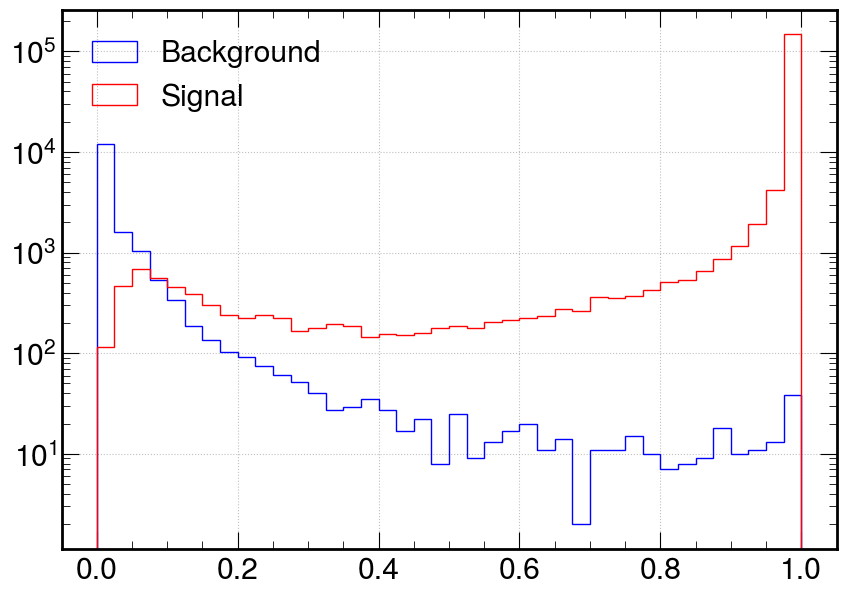

In [163]:
plt.figure(figsize=(10, 7))
plt.hist(pred_proba_test[y_test == 0], bins=np.linspace(0, 1, 41), histtype='step', label='Background', color='b')
plt.hist(pred_proba_test[y_test == 1], bins=np.linspace(0, 1, 41), histtype='step', label='Signal', color='r')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

Let's have a look at the impact on the missing mass spectrum at a decision boundary of 0.2 for the test events which are background-like.

In [165]:
# Add truth labels to X frames
X_test = X_test.with_columns(pl.lit(y_test).alias('isSignal'))
X_train = X_train.with_columns(pl.lit(y_train).alias('isSignal'))

In [166]:
X_test = X_test.with_columns(pl.Series("pred", pred_proba_test))
X_train = X_train.with_columns(pl.Series("pred", pred_proba_train))

<Figure size 1000x1000 with 0 Axes>

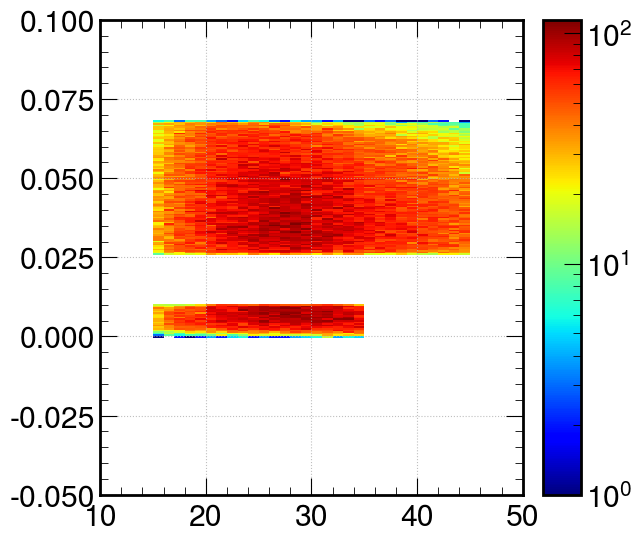

In [167]:
missing_mass_plot(X_test.filter(pl.col("isSignal").eq(1)))

In [168]:
def get_fpr(conf_matrix):
    return conf_matrix[0][1] / np.sum(conf_matrix[0])

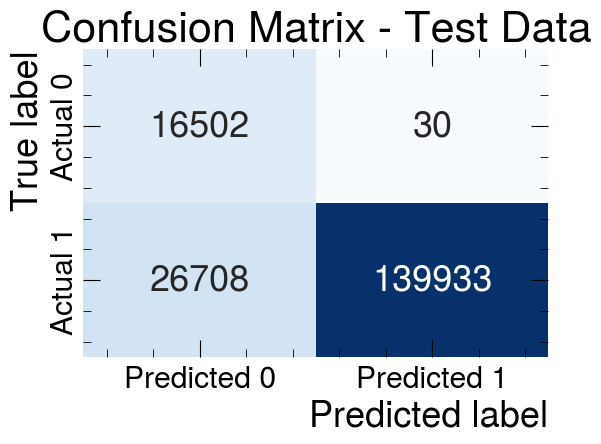

In [169]:
# Now lets get the raw counts via a confusion matrix and a custom deicision boundary
conf_matrix = confusion_matrix(y_test.to_numpy().astype(np.float64), pred_proba_test > 0.99)
#sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Test Data')
plt.show()

In [170]:
get_fpr(conf_matrix)

0.0018146624727800628

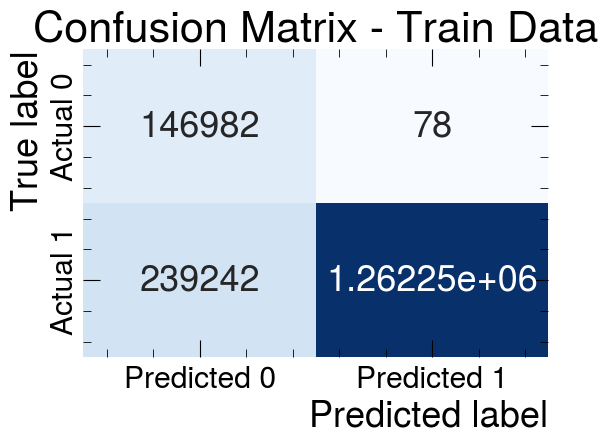

In [171]:
# Now lets get the raw counts via a confusion matrix and a custom deicision boundary
conf_matrix = confusion_matrix(y_train.to_numpy().astype(np.float64), pred_proba_train > 0.99)
#sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Train Data')
plt.show()

In [172]:
get_fpr(conf_matrix)

0.0005303957568339454

Evidence of overtraining from the confusion matrices, however the changes to the parameters were a step in the correct direction.

## Evaluation Samples
We need a good reference point to see how the models (both) perform. I will do this using the full signal selection with only the current BDT cut not applied for Kpinn non-overlaid MC. We are looking for direct increases/stability in this count. 

Then of major importance is how we look in data. Obvioulsy the training and testing samples can only show us so much. These training samples are constrained to the signal region and are very much like the signal selection except that:
1. No GTK extra hits veto is applied (inside of IsUpstream)
2. Out-of-time
3. CDA > 4 mm to replace standard K-pi matching conditions.

Note our signal training sample is the full signal selection excluding the veto counter and trapezoid cut.

To actually test we define some different background samples, constrained again to the signal region and has the signal selection other than:
1. Require hits in the VC and a large CDA.
2. A large CDA and outside of the trapezoid in $R_{STRAW1}$ versus $Z_{vtx}$ space.

In [173]:
# Cleanup memory
del X_test, X_train, y_test, y_train, signal, bkg, df

In [174]:
model = Booster()
model.load_model("models/baseline3.xgb")

In [175]:
column_names += ["region", "isUpsTMVA"]

In [176]:
sigEval = pl.read_csv("data/BDT_Eval_KpinnNoov_SigEval.txt", has_header=False)
sigEval = sigEval.drop("column_23")
sigEval.columns = column_names

In [177]:
bkgEval = pl.read_csv("data/BDT_Eval_2022_Bkg1.txt", has_header=False)
bkgEval = bkgEval.drop("column_23")
bkgEval.columns = column_names

The current acceptance of signal for the current TMVA, recall this is non-overlaid. Recall when we have a "1" in isUpsTMVA it is because the BDT believes the event is upstream-like and so will be vetoed.

In [178]:
sigProba = model.predict(xgb.DMatrix(sigEval[features].to_numpy().astype(np.float64)))
bkgProba = model.predict(xgb.DMatrix(bkgEval[features].to_numpy().astype(np.float64)))

# Add predictions onto each frame
sigEval = sigEval.with_columns(pl.Series("pred", sigProba))
bkgEval = bkgEval.with_columns(pl.Series("pred", bkgProba))

### Signal Acceptances
We look at the signal acceptance both within and outside the signal regions.

In [195]:
sigAccTMVA = (len(sigEval) - np.count_nonzero(sigEval.select("isUpsTMVA"))) / len(sigEval)
sigAccBDT = np.count_nonzero(sigEval.select("pred") > 0.992) / len(sigEval)

print("---- All kinematic regions ----")
print(f"Signal acceptance (TMVA) = {sigAccTMVA*100:.2f}%")
print(f"Signal acceptance (BDT) = {sigAccBDT*100:.2f}%")

---- All kinematic regions ----
Signal acceptance (TMVA) = 81.61%
Signal acceptance (BDT) = 83.23%


In [180]:
sigEvalSR = sigEval.filter(
    (pl.col("region").eq(1)) | (pl.col("region").eq(2))
)

In [196]:
# Now constrian to just the signal regions
nSignalRegion = len(sigEvalSR)

sigAccTMVA = (nSignalRegion - np.count_nonzero(sigEvalSR.select("isUpsTMVA"))) / nSignalRegion
sigAccBDT = np.count_nonzero(sigEvalSR.select("pred") > 0.992) / nSignalRegion

print("---- Signal regions only ----")
print(f"Signal acceptance (TMVA) = {sigAccTMVA*100:.2f}%")
print(f"Signal acceptance (BDT) = {sigAccBDT*100:.2f}%")

---- Signal regions only ----
Signal acceptance (TMVA) = 82.89%
Signal acceptance (BDT) = 84.60%


So a remarkable increase in the signal acceptance at the somewhat arbitrary decision threshold of 0.1. I expect the backgrounds are just going to be completely out of control.

### Background Acceptances
Again we look at the two base samples to start with. For a final evaluation we can use sampleC and the entire of 2022 with the standard signal selection (obviously changing the TMVA for the BDT).

In [197]:
bkgAccTMVA = (len(bkgEval) - np.count_nonzero(bkgEval.select("isUpsTMVA"))) / len(bkgEval)
bkgAccBDT = np.count_nonzero(bkgEval.select("pred") > 0.992) / len(bkgEval)

print("---- All kinematic regions ----")
print(f"Bkg1 acceptance (TMVA) = {bkgAccTMVA*100:.2f}%")
print(f"Bkg1 acceptance (BDT) = {bkgAccBDT*100:.2f}%")

---- All kinematic regions ----
Bkg1 acceptance (TMVA) = 2.31%
Bkg1 acceptance (BDT) = 2.09%


Wow, actually terrible performance. Is there much change when we constrict to only the signal regions?

In [183]:
bkgEvalSR = bkgEval.filter(
    (pl.col("region").eq(1)) | (pl.col("region").eq(2))
)

In [198]:
# Now constrian to just the signal regions
nSignalRegion = len(bkgEvalSR)

bkgAccTMVA = (nSignalRegion - np.count_nonzero(bkgEvalSR.select("isUpsTMVA"))) / nSignalRegion
bkgAccBDT = np.count_nonzero(bkgEvalSR.select("pred") > 0.992) / nSignalRegion

print("---- Signal regions only ----")
print(f"Signal acceptance (TMVA) = {bkgAccTMVA*100:.2f}%")
print(f"Signal acceptance (BDT) = {bkgAccBDT*100:.2f}%")

---- Signal regions only ----
Signal acceptance (TMVA) = 1.16%
Signal acceptance (BDT) = 0.98%


Even worse! Wow we have got a lot of work to do. Lets look at the missing mass plots.

In [199]:
print(np.count_nonzero(bkgEvalSR.select("pred") > 0.992)) # Number of background events BDT wrongly accepts as signal (in SR)
print((nSignalRegion - np.count_nonzero(bkgEvalSR.select("isUpsTMVA")))) # Number of background events TMVA wrongly accepts as signal (in SR)

47
56


<Figure size 1000x1000 with 0 Axes>

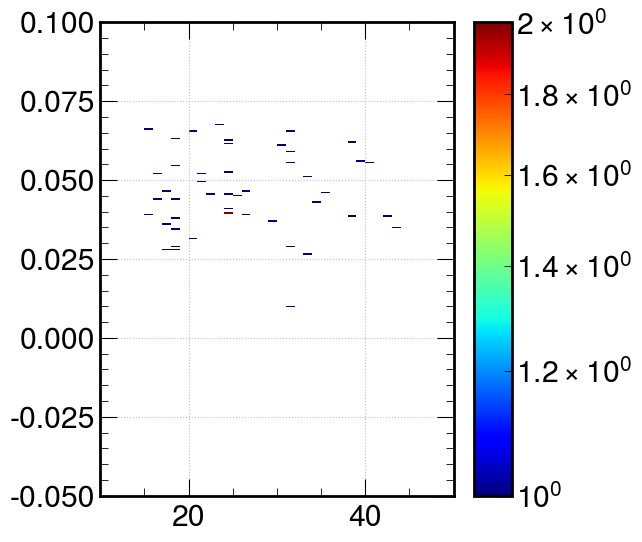

In [201]:
missing_mass_plot(bkgEvalSR.filter(pl.col("pred").gt(0.992)))

<Figure size 1000x1000 with 0 Axes>

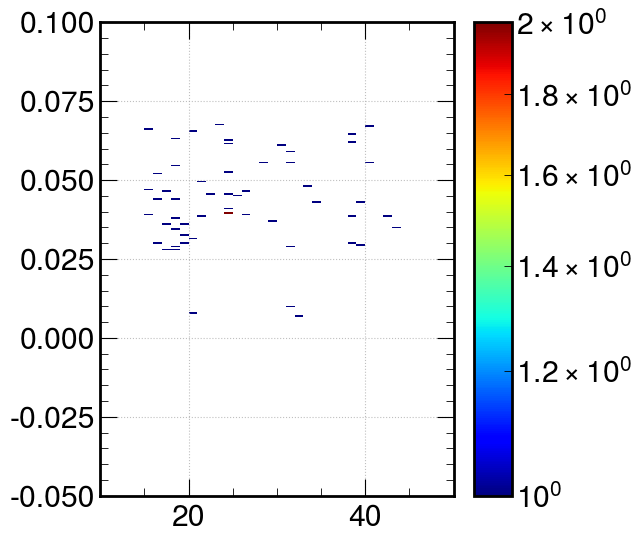

In [202]:
missing_mass_plot(bkgEvalSR.filter(pl.col("isUpsTMVA").eq(0)))